# Calculate composite network response

In [70]:
import h5py
import glob
import obspy
import os
import numpy as np
import tqdm

from beamnetresponse.beamformed_nr import composite_network_response
from matplotlib import pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import hilbert, find_peaks
from scipy.stats import median_abs_deviation

## Read travel times

The velocity model of Karabulut et al. (2011) is downloaded and accessed with `pandas`. The model is given in meters for the depth and in m/s for the speed values. Everything is converted to km for the later compatibility with `pykonal`. 

In [71]:
DIRPATH_WAVEFORMS = "../data_processed/*.mseed"
DIRPATH_RAW = "../data/"
FILEPATH_TRAVELTIMES = "../data/trave_times.h5"
FILEPATHS_WAVEFORMS = glob.glob(DIRPATH_WAVEFORMS)
SEISMIC_PHASES = ["Vp", "Vs"]

# Get sampling rate
header = obspy.read(FILEPATHS_WAVEFORMS[0], headonly=True)
sampling_rate = header[0].stats.sampling_rate

# Load h5
travel_times = dict()
with h5py.File(FILEPATH_TRAVELTIMES, mode="r") as root:

    stations = list(root[SEISMIC_PHASES[0]].keys())
    grid_size = root[SEISMIC_PHASES[0]][stations[0]].size
    travel_times = np.zeros((len(SEISMIC_PHASES), len(stations), grid_size))

    # 
    for phase_id, phase in enumerate(SEISMIC_PHASES):
        for station_id, station in enumerate(stations):     
            travel_times[phase_id][station_id] = root[phase][station][:].ravel()
    
# Reshape for beamnetresponse
travel_times = travel_times.transpose(-1, 1, 0)

# Turn to moveouts in samples
moveouts = travel_times - np.min(travel_times, axis=(1, 2), keepdims=True)
moveouts = np.round(sampling_rate * travel_times).astype(np.int32)

## Envelopes

In [3]:
CHANNELS = ["N", "E", "Z"]

features = np.zeros(
    (len(stations), len(CHANNELS), header[0].stats.npts), dtype=np.float32
)

for filepath in tqdm.tqdm(FILEPATHS_WAVEFORMS):

    # Read trace
    stream = obspy.read(filepath)
    station = stream[0].stats.network + "." + stream[0].stats.station
    channel = stream[0].stats.channel
    data = stream[0].data

    # Get coordinate
    station_id = stations.index(station)
    channel_id = CHANNELS.index(channel[-1])

    # Calculate features
    feature_norm = median_abs_deviation(data)
    feature_norm = 1.0 if feature_norm == 0.0 else feature_norm
    
    # Envelope
    feature = np.abs(hilbert(data / feature_norm)).astype(np.float32)
    features[station_id, channel_id] = feature.clip(
        np.min(feature),
        10.0 ** (5.0 * median_abs_deviation(feature)),
    )

100%|██████████| 24/24 [00:06<00:00,  3.50it/s]


## Show an example envelope

(-24.448483718931676, 24.448483718931676)

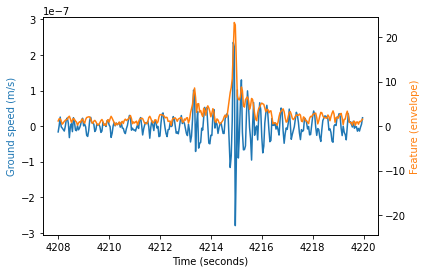

In [4]:
START, END = 105200, 105500

stream = obspy.read(FILEPATHS_WAVEFORMS[0])
station = stream[0].stats.network + "." + stream[0].stats.station
channel = stream[0].stats.channel
data = stream[0].data[START:END]
times = stream[0].times()[START:END]

# Get coordinate
station_id = stations.index(station)
channel_id = CHANNELS.index(channel[-1])
station_id = stations.index(station)
channel_id = CHANNELS.index(channel[-1])

# Plot
fig, ax = plt.subplots()
ax.plot(times, data)
ymax = max(np.abs(ax.get_ylim()))
ax.set_ylim(-ymax, ymax)
ax.set_ylabel("Ground speed (m/s)", color="C0")
ax.set_xlabel("Time (seconds)")

# Envelope on a second axe (not the same scale)
axf = ax.twinx()
axf.plot(times, features[station_id, channel_id, START:END], "C1")
axf.set_ylabel("Feature (envelope)", color="C1")
ymax = max(np.abs(axf.get_ylim()))
axf.set_ylim(-ymax, ymax)


## Source and phase weights

In [5]:
weight_shape = (*features.shape[:-1], len(SEISMIC_PHASES))
weights_phase = np.ones(weight_shape, dtype=np.float32)
weights_phase[:, :2, 0] = 0.0
weights_phase[:, 2, 1] = 0.0
weights_sources = np.ones(travel_times.shape[:-1], dtype=np.float32)

response, source_id = composite_network_response(
    features, moveouts, weights_phase, weights_sources, device="cpu"
)

## Detect

In [48]:
MIN_INTERVAL = int(20 * sampling_rate)
MADMED_RATIO = 15

# Temporal
window_length = int(1800 * sampling_rate)
window_step = int((3 * window_length) // 4)
calendar_times = stream[0].times()
calendar_times_slider = calendar_times[::window_step][:-1]

# Threshold
response_slider = sliding_window_view(response, window_length)
response_slider = response_slider[::window_step]
response_median = np.median(response_slider, axis=-1)
response_mad = median_abs_deviation(response_slider, axis=-1)
threshold = response_median + MADMED_RATIO * response_mad

# Interpolation
threshold = np.interp(calendar_times, calendar_times_slider, threshold)

# Detection
peaks = find_peaks(response, distance=MIN_INTERVAL, height=threshold)

In [95]:
WAVEFORM_ID = 10

# The surface extents are in degrees, the depth positive downwards and in km
WEST, EAST, SOUTH, NORTH, DOWN, UP = 30.20, 30.45, 40.60, 40.76, 30.0, -2.0
GRID_SIZE = N_DEPTH, N_LAT, N_LON = 50, 20, 30

# Interpolate
depths = np.linspace(UP, DOWN, N_DEPTH)
longitudes = np.linspace(WEST, EAST, N_LON)
latitudes = np.linspace(SOUTH, NORTH, N_LAT)

grid = np.meshgrid(longitudes, latitudes, depths, indexing="ij")
coordinates = np.array([coordinate.ravel() for coordinate in grid])

source_id_sel = source_id[peaks[0][WAVEFORM_ID]]
source_coordinates = [coordinate[source_id_sel] for coordinate in coordinates]

In [96]:
WINDOW_VIEW_EXTENT_SEC = 5

# Show composite response versus time
plt.plot(calendar_times, response, rasterized=True)
plt.plot(calendar_times, threshold, rasterized=True)
for index, (peak_id, peak_height) in enumerate(
    zip(peaks[0], peaks[1]["peak_heights"])
):
    plt.plot(calendar_times[peak_id], peak_height, "r.")
    if index == WAVEFORM_ID:
        plt.plot(calendar_times[peak_id], peak_height, "k.")

# Labels
plt.legend(["Response", "Threshold", "Detection"])
plt.xlabel("Times (seconds)")
plt.ylabel("Composite network response")
plt.yscale("log")
plt.ylim(bottom=10)
plt.grid()
plt.show()

fig, ax = plt.subplots(1)
for trace in obspy.read(DIRPATH_WAVEFORMS):

    date = calendar_times[peaks[0][WAVEFORM_ID]]
    date = trace.stats.starttime + date
    
    trace.trim(
        starttime=date - WINDOW_VIEW_EXTENT_SEC,
        endtime=date + 2 * WINDOW_VIEW_EXTENT_SEC,
    )

    # Attach response
    filepath_inventory = f"{trace.stats.network}.{trace.stats.station}.xml"
    filepath_inventory = os.path.join(DIRPATH_RAW, filepath_inventory)
    inventory = obspy.read_inventory(filepath_inventory)
    station_coordinates = inventory.get_coordinates(trace.id)

    # Distance
    p1 = station_coordinates["latitude"], station_coordinates["longitude"]
    p2 = source_coordinates[0], source_coordinates[1]
    distance = obspy.geodetics.base.locations2degrees(*p1, *p2)

    # Plot
    ax.plot(trace.times(), 400 * trace.data + distance, "k", rasterized=True)

ax.set_ylabel("Epicentral distance (deg)")
ax.set_xlabel("Local time (seconds)")
